# Sequence to Sequence models for sugar level prediction

For the first part, which make use of Recurrent Neural Networks, 
take a look at https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

The second part (to be done) will use the more advanced Transformer arquitecture. 

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

In [0]:
from tensorflow.keras.layers import Dense, LSTM, Input, RepeatVector, concatenate
from tensorflow.keras.layers import Embedding, GaussianNoise, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MAE
from tensorflow.keras.metrics import MAPE, MSE
from tensorflow.keras.backend import clear_session
from tensorflow.keras.constraints import max_norm

## Data preprocessing

### Load datasets

Each dataset consits of sequences of `history`+`future` points, with 4 features: 

* time interval: days counted starting from the end of the `history` of the sequence. Thus, for points in the `history`, this feature takes negatuve values, while for points in the `future`, it's positive. 
* hour: hour of the day, divided by 24.
* day of week: day of the week in numbers ('Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6), divided by 7.
* sugar level: recorded sugar level, scaled with min/max scaler.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root = "/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/"
noise=0.0
history = 48 * 4
future = 3 * 4

noise=0.0
replace=False

train = np.load(os.path.join(root, "noise_%s_train_steps_%s_replace_%s.npy" %(noise, int(history), replace)))
vad = np.load(os.path.join(root, "noise_%s_vad_steps_%s_replace_%s.npy" %(noise, int(history), replace)))
test = np.load(os.path.join(root, "noise_%s_test_steps_%s_replace_%s.npy" %(noise, int(history), replace)))

train_batch = 500
vad_batch = 500
test_batch = 500

train_steps = train.shape[0] // train_batch
vad_steps = vad.shape[0] // train_batch
test_steps = test.shape[0] // test_batch

assert history+future == train.shape[1]

In [0]:
np.random.seed(1203)
np.random.shuffle(train)

###  Split data 

Each input sequence has both the features and labels (x and y, if you wish), so we have to separate them.

In [0]:
def split_features_labels(data, history, future, start_char):
    """
    Method to separate historic and future events (features and labels). 
    It returns input data for the encoder and decoder, and the output data 
    for the decoder. The input data for the decoder is just the output data 
    of the decoder, shifted by one step. 

    :param data: numpy ndarray with sequences of history+future points, and 4 attributes 
      (time_interval, hour_of_day, day_of_week, sugar_level). It has shape (?, history+future, 4)
    :param history: number of points for the features
    :param future: number of points for the labels
    :param start_char: start charcter for input sequences to the decoder
    :return three numpy arrays with the input data for the encoder (shape=(?, history, 4))
        and decoder (shape=(?, future+1, 1)), and the output data for the decoder
        (shape=(?, future+1, 1))
    """
    # split features and labels . Note that for the later, we only keep the 
    # feature with the sugar level, which constitutes our target
    yf, yl = data[:, :history], data[:, history:history+future, -1]
    
    # add start of sentence to labels (input to the decoder)
    yl_input = start_char * np.ones(shape=(yl.shape[0], yl.shape[1]+1))
    yl_input[:, 1:] = yl
    # add end of sentence to labels (output of the decoder)
    yl_output = start_char * np.ones(shape=(yl.shape[0], yl.shape[1]+1))
    yl_output[:, :-1] = yl
    
    # add new dimension at the end of input/output arrays to the decoder
    yl_input = yl_input[:, :, np.newaxis].astype(np.float32)
    yl_output = yl_output[:, :, np.newaxis].astype(np.float32)
    
    return (yf, yl_input), yl_output

In [0]:
start_char = -1.0
train_data = split_features_labels(train, history, future, start_char)
vad_data = split_features_labels(vad, history, future, start_char)
test_data = split_features_labels(test, history, future, start_char)

In [9]:
train_data[0][0].shape, train_data[0][1].shape, train_data[1].shape

((76785, 192, 4), (76785, 13, 1), (76785, 13, 1))

In [10]:
print(np.unique(train_data[0][0][:, :, 1]))
print(np.unique(train_data[0][0][:, :, 2]))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]
[0. 1. 2. 3. 4. 5. 6.]


## Some auxiliar functions 



In [0]:
def plot_train_history(history, title, metric):
  loss = history[metric]
  val_loss = history['val_%s' %metric]

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training %s' %metric)
  plt.plot(epochs, val_loss, 'r', label='Validation %s' %metric)
  plt.title(title)
  plt.legend()

  plt.yscale('log')
  plt.show()

def plot_results(dataset, prediction, history, future):
    plt.figure(figsize=(12, 6))

    # get random idx
    idx = np.random.randint(0, dataset.shape[0])

    # get intervals
    xf = dataset[idx, :history, 0]
    xl = dataset[idx, history:history+future, 0]
    
    # get sequences
    input_seq_ = dataset[idx, :history, -1]
    target_seq_ = dataset[idx, history:history+future, -1]
    decoded_seq_ = prediction[idx, :]

    ymin = input_seq_.min()-0.1
    ymax = input_seq_.max()+0.1
    
    plt.plot(xf, input_seq_, '-b', markersize=2, linewidth=2, label='historic data')
    plt.plot(xl, target_seq_, '.--b', markersize=2, linewidth=2, label='future data')
    plt.plot(xl, decoded_seq_, '.--k', markersize=2, linewidth=2, label='prediction')
    plt.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linewidth=1, linestyles='--')

    plt.ylim(ymin, ymax)
    plt.xlim(-0.3-history/4/24, future/4/24+0.3)
    
    plt.ylabel('Glucose evolution (arb.units)')
    plt.xlabel('Days before/after start prediction')
    plt.legend(loc='best')

    plt.show()

In [0]:
def mae(dataset, prediction, history, future):
    expected = dataset[:, history:history+future, -1]
    return np.mean(np.abs(expected - prediction))

def plot_metric(arr):
    x = arr[:, 0]
    y = arr[:, 1]
    z = arr[:, 2]
    
    plt.figure()
    plt.title('MAE error')
    plt.plot(x, y,  '.--k', markersize=5, linewidth=2, label='train')
    plt.plot(x, z,  '.--b', markersize=5, linewidth=2, label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Average Error')
    plt.legend(loc='best')
    plt.show()

## Seq2Seq model 

### Model

In [0]:
def process_input(out_cat_dim, out_dim, activation, noise):
    """
    Method to process categorical/numerical features and add noise.
    Features are next concatenate and passed through a Dense layer.

    :param out_cat_dim: tuple with output dimensions of categorcial embeddings
        (For day_of_week and hour_of_day variables)
    :param out_dim: final output dimension after the Dense layer. 
    :param activation: activation of the final Dense layer
    :param noise: noise level used in the GaussianNoise layer (aka, stddev)
    :return a list of Input layers (time_interval, day_of_week, hour_of_day, sugar_level),
        as well as the processed inputs (a layer of shape=(batch_size, None, out_dim))
    """
    # Define Input layers for numerical and categorical variables
    day_of_week = Input(shape=(None, ))
    hour_of_day = Input(shape=(None, ))
    time_interval = Input(shape=(None, 1))
    sugar_level = Input(shape=(None, 1))
    tensor_inputs = [time_interval, hour_of_day, day_of_week, sugar_level]

    # create embeddings for categorical variables
    day_of_week = Embedding(input_dim=7, output_dim=out_cat_dim[0])(day_of_week)
    hour_of_day = Embedding(input_dim=24, output_dim=out_cat_dim[0])(hour_of_day)
    
    # Add noise to sugar level feature
    if noise > 0.0:
        sugar_level = GaussianNoise(stddev=noise)(sugar_level)

    # Concatenate all inputs toghether, and pass them through a dense layer
    inputs = concatenate([time_interval, hour_of_day, day_of_week, sugar_level], axis=-1)
    inputs = Dense(out_dim, activation=activation)(inputs)
    
    return tensor_inputs, inputs

def encoder(out_cat_dim, out_dim, activation, noise, latent_dim, 
            num_layers, mn_rec, dropout, recurrent_dropout):
    """
    Encode sequences with LSTMs 

    :param out_cat_dim: tuple with output dimensions of categorcial embeddings
        (For day_of_week and hour_of_day variables)
    :param out_dim: final output dimension after the Dense layer. 
    :param activation: activation of the final Dense layer
    :param noise: noise level used in the GaussianNoise layer (aka, stddev)
    :param latent_dim: dimension of the encoding vectors
    :param num_features_cat: number of input categorical features
    :param num_features_num: number of input numerical features
    :param num_layers: number of stack layers. Last layer only returns states
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return encoder input and output states, and last output of the sequence
    """
    # process input data: categorical variables, noise, etc.
    tensor_inputs, inputs = process_input(out_cat_dim, out_dim, activation, noise)
    
    # for loop to stack lstms, with returning sequences
    for i in np.arange(num_layers-1):
       lstm_ = LSTM(latent_dim, return_sequences=True, 
                    kernel_constraint=max_norm(mn_rec),
                    recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                    recurrent_dropout=recurrent_dropout)
       inputs = lstm_(inputs)

    # the last lstm returns the states, which will be use to feed the decoder
    encoder = LSTM(latent_dim, return_state=True, 
                   kernel_constraint=max_norm(mn_rec), 
                   recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                   recurrent_dropout=recurrent_dropout)
    encoder_output, state_h, state_c = encoder(inputs)
    encoder_states = [state_h, state_c]

    return tensor_inputs, encoder_states, encoder_output

def decoder(encoder_states, encoder_output, latent_dim, 
            num_layers, layers_dense,
            future_steps, activation_dense, mn_dense, mn_rec, 
            dropout, recurrent_dropout):
    """
    Decoder with LSTM 
    
    :param encoder_satates: list of tensors with the LSTM states (cell and hidden)
    :param encoder_output: last output of the sequence
    :param latent_dim: dimension of the decoding vectors
    :param future_steps: number of predictions. 
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return decoder input and output sequences
    """
    # use encoder_output as input to the decoder
    decoder_inputs = RepeatVector(future_steps)(encoder_output)

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the 
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        kernel_constraint=max_norm(mn_rec), 
                        recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                        recurrent_dropout=recurrent_dropout)
    lstm_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    
    # MLP for output sequences
    input_mlp = lstm_outputs
    for neurons in layers_dense:
        decoder_dense = Dense(neurons, activation='selu', 
                              kernel_constraint=max_norm(mn_dense))
        input_mlp = decoder_dense(input_mlp)
    decoder_outputs = input_mlp
 
    return decoder_inputs, decoder_outputs

def seq2seq(history, future, latent_dim, out_cat_dim, out_dim_input, activation_input, 
            noise_input, num_layers_enc, num_layers_dec, layers_dense,
            activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout):
    """

    :param history: number of steps of input sequence
    :param future: number of steps of output sequence
    :param latent_dim: dimension of the encoding/decoding vectors
    :param out_cat_dim: tuple with output dimensions of categorcial embeddings
        (For day_of_week and hour_of_day variables)
    :param out_dim_input: final output dimension after the Dense layer in the
        initial preprocessing
    :param activation_input: activation of the final Dense layer in the 
        initial preprocessing
    :param noise_input: noise level used in the GaussianNoise layer (aka, stddev)
        in the initial preprocessing
    :param num_layers_enc: number of stack layers in the encoder. 
        Last layer only returns states
    :param num_layers_dec: number of stack layers in the decoder. Not used yet.
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return the model
    """
    clear_session()

    # encode
    encoder_inputs, encoder_states, encoder_output = encoder(
        out_cat_dim, out_dim_input, activation_input, noise_input, latent_dim, 
        num_layers_enc, mn_rec, dropout, recurrent_dropout)

    # decode
    decoder_inputs, decoder_outputs = decoder(
        encoder_states, encoder_output, latent_dim, num_layers_dec,
        layers_dense, future, activation_dense, mn_dense, 
        mn_rec, dropout, recurrent_dropout)

    # Training model
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs, 
                  name='seq2seq_training_model')
    print(model.summary())

    return model

### Training

In [0]:
def get_columns(data):
    """
    Split and prepare input data

    :param data: array with four columns: time_interval, hour_of_day, 
        day_of_week, sugar_level
    """
    time_interval, hour_of_day, day_of_week, sugar_level = np.split(data, 
        indices_or_sections=4, axis=2)
    # squeeze categorical features (ncessary for the Embedding layer)
    hour_of_day = np.squeeze(hour_of_day, axis=2)
    day_of_week = np.squeeze(day_of_week, axis=2)
    return [time_interval, hour_of_day, day_of_week, sugar_level]

def train_seq2seq(train_data, vad_data, train, vad, history, future, start_char, 
                  latent_dim, out_cat_dim, out_dim_input, activation_input, 
                  noise_input, num_layers_enc, num_layers_dec, layers_dense, 
                  activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
                  lr, clip_value, num_epochs, train_batch, loss, metric, verbose):
    m = seq2seq(history, future,
                latent_dim=neurons,
                out_cat_dim=out_cat_dim,
                out_dim_input=out_dim_input,
                activation_input=activation_input,
                noise_input=noise_input,
                num_layers_enc=num_layers_enc,
                num_layers_dec=num_layers_dec,
                layers_dense=layers_dense,
                activation_dense=activation_dense,
                mn_dense=mn_dense,
                mn_rec=mn_rec,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout)

    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=clip_value), 
              loss=loss, metrics=[metric])

    # we remove the end of sentence from target data (used in more complicated models)
    input_train = get_columns(train_data[0][0])
    target_train = train_data[1][:, :-1]

    input_vad = get_columns(vad_data[0][0])
    target_vad = vad_data[1][:, :-1]

    h = m.fit(x=input_train, y=target_train, batch_size=train_batch, epochs=num_epochs, 
              validation_data=(input_vad, target_vad))
    
    training_logs = h.history

    # get predictions for the validation set
    prediction_vad = m.predict(input_vad, batch_size=500, verbose=True)

    for _ in np.arange(4):
        plot_results(vad, prediction_vad, history, future)

    plot_train_history(training_logs, 'Seq2Seq', metric='loss')
    plot_train_history(training_logs, 'Seq2Seq', metric=metric)

    return m, training_logs

Model: "seq2seq_training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 3)      72          input_2[0][0]                    
_____________________________________________________________________________

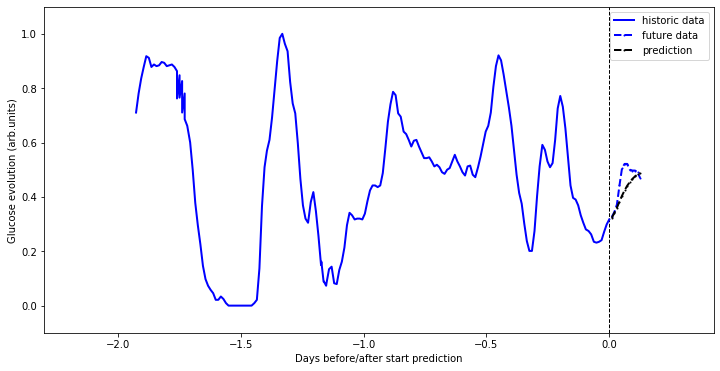

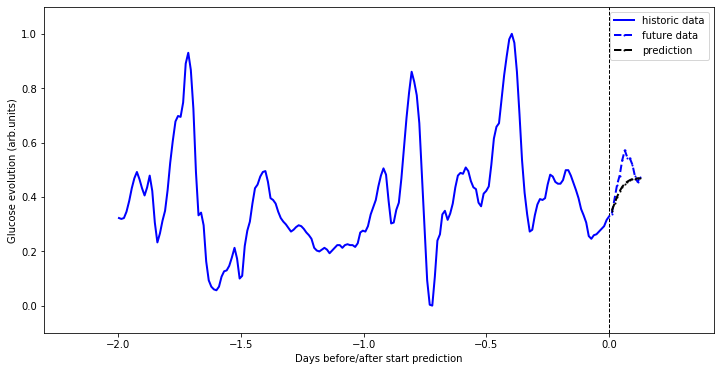

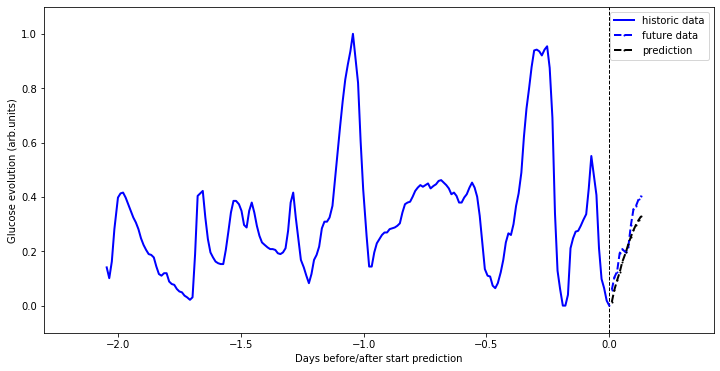

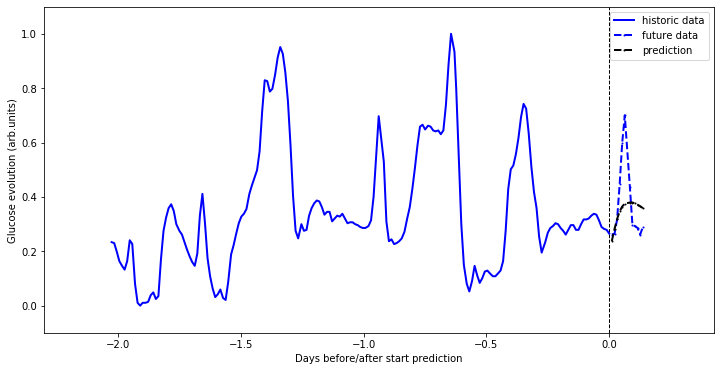

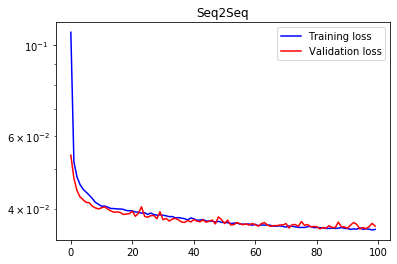

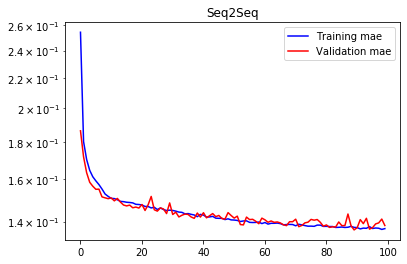

In [21]:
num_epochs = 100

num_layers_enc = 1
num_layers_dec = None
layers_dense = [64, 32, 8, 1]
neurons = 128

out_cat_dim = (3, 3) 
out_dim_input = 20 
activation_input = 'selu'
noise_input = 0.0

mn_dense = 0.5
mn_rec = 0.1
activation_dense = 'selu'

clip_value = 0.5
lr = 5e-4

# droput in the input to the RNN does not work well. Better add Gaussian Noise
dropout = 0.0
# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  

verbose = False

metric = 'mae'
loss = MSE

m, training_logs = train_seq2seq(train_data, vad_data, train, vad, 
    history, future, start_char, neurons, out_cat_dim, out_dim_input, 
    activation_input, noise_input, num_layers_enc, num_layers_dec, layers_dense, 
    activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
    lr, clip_value, num_epochs, train_batch, loss, metric, verbose)


### Some results

* 1 day feature steps, 3 hours for label steps: 

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 0.3, mn_rec = 0.1:

     loss: 0.0498 - mae: 0.1603 - val_loss: 0.0504 - val_mae: 0.1598

* 2 day feature steps, 3 hours for label steps: 

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 0.3, mn_rec = 0.05:

    loss: 0.0376 - mae: 0.1425 - val_loss: 0.0374 - val_mae: 0.1410

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 0.3, mn_rec = 0.1:

    loss: 0.0359 - mae: 0.1375 - val_loss: 0.0353 - val_mae: 0.1358

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 0.3, mn_rec = 0.2:

    loss: 0.0317 - mae: 0.1288 - val_loss: 0.0371 - val_mae: 0.1388
    
  * **layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 0.5, mn_rec = 0.1:**

    **loss: 0.0355 - mae: 0.1367 - val_loss: 0.0355 - val_mae: 0.1355**

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 1.0, mn_rec = 0.1:

    loss: 0.0350 - mae: 0.1354 - val_loss: 0.0364 - val_mae: 0.1386

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 10, mn_dense = 0.3, mn_rec = 0.1:

    loss: 0.0362 - mae: 0.1381 - val_loss: 0.0360 - val_mae: 0.1394

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 50, mn_dense = 0.3, mn_rec = 0.1:

    loss: 0.0356 - mae: 0.1369 - val_loss: 0.0363 - val_mae: 0.1383
* 3 day feature steps, 3 hours for label steps: 


## Seq2seq model with Teacher Forcing

### Models: encoder and decoder


In [0]:
def encoder_force(latent_dim, num_features, num_layers, mn_rec, dropout, recurrent_dropout):
    """
    Encode sequences with LSTMs 

    :param latent_dim: dimension of the encoding vectors
    :param num_features: number of input features
    :param num_layers: number of stack layers. Last layer only returns states
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return encoder input, output states and last output sequence; and the inference model
    """
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_features))

    # for loop to stack lstms, with returning sequences
    input_ = encoder_inputs
    for i in np.arange(num_layers-1):
       lstm_ = LSTM(latent_dim, return_sequences=True, 
                    kernel_constraint=max_norm(mn_rec),
                    recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                   recurrent_dropout=recurrent_dropout)
       input_ = lstm_(input_)

    # the last lstm returns the states, which will be use to feed the decoder
    encoder = LSTM(latent_dim, return_state=True, 
                   kernel_constraint=max_norm(mn_rec), 
                   recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                   recurrent_dropout=recurrent_dropout)
    encoder_output, state_h, state_c = encoder(input_)
    encoder_states = [state_h, state_c]
    print('Encoder output shape', encoder_output.shape)
    
    # model to perform inference with the encoder
    encoder_model = Model(inputs=encoder_inputs, 
                          outputs=[encoder_output] + encoder_states, 
                          name='encoder_model_inference')
    
    print('Encoder done')

    return encoder_inputs, encoder_states, encoder_output, encoder_model

def decoder_force(encoder_states, encoder_output, latent_dim, future_steps, 
                  layers_dense, activation_dense, mn_dense, mn_rec, dropout, 
                  recurrent_dropout):
    """
    Decoder with LSTM 
    
    :param encoder_satates: list of tensors with the LSTM states (cell and hidden)
    :param encoder_output: last output of the encoder sequence
    :param latent_dim: dimension of the decoding vectors
    :param future_steps: number of prediction steps to be made. We add one more 
      step for the end of target sequence
    :param layers_dense: list with the number of neurons for each layer in the final mlp
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return decoder input and output sequences, and the inference model
    """
    # Define an input sequence and process it.
    decoder_inputs_seq = Input(shape=(None, 1))
    # Also use encoder ouptut as input 
    decoder_inputs_enc = RepeatVector(future_steps+1)(encoder_output)
    # feed as a list
    decoder_inputs = concatenate(inputs=[decoder_inputs_seq, decoder_inputs_enc], axis=-1)
    print('Decoder input done', decoder_inputs_seq.shape, decoder_inputs_enc.shape, decoder_inputs.shape)

    # Set up the decoder, using `encoder_states` as initial state.
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the 
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        kernel_constraint=max_norm(mn_rec), 
                        recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                        recurrent_dropout=recurrent_dropout)
    lstm_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    print('Decoder lstm done', lstm_outputs.shape)
    # MLP for output sequences
    input_mlp = lstm_outputs
    mlp = []
    for neurons in layers_dense:
        decoder_dense = Dense(neurons, activation='selu', 
                              kernel_constraint=max_norm(mn_dense))
        mlp.append(decoder_dense)
        input_mlp = decoder_dense(input_mlp)
    decoder_outputs = input_mlp
    print('Decoder train done', input_mlp.shape)

    # model to perform inference with the decoder

    # inputs to cell and state (to be feed from the encoder last states, or others!)
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    print('Decoder inference input states done')

    # Input sequences: here, we do not repeat the encoder_output vector, as we 
    # perform inference one step after another
    encoder_output_inf = Input(shape=(latent_dim))
    decoder_inputs_inf = RepeatVector(1)(encoder_output_inf)
    decoder_inputs_inf = concatenate(
        inputs=[decoder_inputs_seq, decoder_inputs_inf], axis=-1)
    print('Decoder inference inputs seq done', decoder_inputs_seq.shape, encoder_output_inf.shape, decoder_inputs_inf.shape)

    lstm_outputs_inference, state_h, state_c = decoder_lstm(
        decoder_inputs_inf, initial_state=decoder_states_inputs)
    print('Decoder inference lstm done')

    decoder_states_inference = [state_h, state_c]
    decoder_outputs_inference = lstm_outputs_inference
    for layer in mlp:
        decoder_outputs_inference = layer(decoder_outputs_inference)
    print('Decoder inference mlp done')

    decoder_model = Model(
        inputs=[decoder_inputs_seq, encoder_output_inf] + decoder_states_inputs,
        outputs=[decoder_outputs_inference] + decoder_states_inference,
        name='decoder_model_inference')
    print('Decoder inference done')

    return decoder_inputs_seq, decoder_outputs, decoder_model

def seq2seq_force(history, future, latent_dim, num_features, num_layers_enc,
                  layers_dense, activation_dense, mn_dense, mn_rec, 
                  dropout, recurrent_dropout):
    """

    :param history: number of steps of input sequence
    :param future: number of steps of output sequence
    :param latent_dim: dimension of the encoding/decoding vectors
    :param num_features: number of input features
    :param num_layers_enc: number of stack layers in the encoder. 
        Last layer only returns states
    :param layers_dense: list with the number of neurons for each layer in the final mlp
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return the model
    """
    clear_session()

    # encode
    encoder_inputs, encoder_states, encoder_output, encoder_model = encoder_force(
        latent_dim, num_features, num_layers_enc, mn_rec, dropout, recurrent_dropout)
    print(encoder_model.summary())

    # decode
    print('Building the decoder')
    decoder_inputs, decoder_outputs, decoder_model = decoder_force(
        encoder_states, encoder_output, latent_dim, future, layers_dense,
        activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout)
    print(decoder_model.summary())

    # Training model
    training_model = Model(inputs=[encoder_inputs, decoder_inputs], 
                           outputs=decoder_outputs, 
                           name='seq2seq_training_model')
    print(training_model.summary())

    return training_model, encoder_model, decoder_model

### Inference


In [0]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_steps, start_char, batch_size):
    # Encode the input as state vectors.
    enc_output, enc_state_h, enc_state_c = encoder_model.predict(input_seq)
    states_value = [enc_state_h, enc_state_c]

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((batch_size, 1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[:, 0, 0] = start_char

    # Sampling loop for a batch of sequences
    decoded_seq = np.zeros(shape=(batch_size, num_steps, 1), dtype=np.float)
    for i in np.arange(num_steps):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, enc_output] + states_value)
        
        out = output_tokens[:, 0, 0]
        decoded_seq[:, i, 0] = out

        # Update the target sequence (of length 1).
        target_seq[:, 0, 0] = out

        # Update states
        states_value = [h, c]

    return decoded_seq

def inner_loop(decoded_seq, dataset, encoder_model, decoder_model, history, future, start_char, 
               start, end, num_seq, batch_size, verbose):
    for idx in np.arange(start, end, step=batch_size):
        if idx >0 and verbose and idx % 500 == 0:
            print("Predicted %s sequences" % idx)
        indices = np.arange(idx, idx+batch_size)
        input_seq = dataset[indices, :history, :]
        if batch_size == 1:
            input_seq = input_seq[np.newaxis, :, :]
        decoded_seq_ = decode_sequence(input_seq, encoder_model, decoder_model, 
                                       future, start_char, batch_size)
        decoded_seq[indices, :] = np.squeeze(decoded_seq_)
    return decoded_seq, indices[-1]
    
def decode_sequences(dataset, encoder_model, decoder_model, history, future, start_char, batch_size, verbose=False):
    num_seq = dataset.shape[0]
    num_steps = num_seq // batch_size
    decoded_seq = np.zeros(shape=(num_seq, future))
    
    start = 0
    decoded_seq, last_idx = inner_loop(decoded_seq, dataset, encoder_model, decoder_model, 
                                        history, future, start_char, start, num_seq-batch_size,
                                        num_seq, batch_size, verbose)
    batch_size = num_seq - last_idx -1 
    if batch_size > 0:
        start = last_idx+1
        decoded_seq, last_idx = inner_loop(decoded_seq, dataset, encoder_model, decoder_model, 
                                        history, future, start_char, start, num_seq,
                                        num_seq, batch_size, verbose)            
    return decoded_seq

### Training

In [0]:
def train_seq2seq_force(train_data, vad_data, train, vad, history, future, start_char, 
                        latent_dim, num_features, num_layers_enc, layers_dense,
                        activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
                        lr, clip_value, num_epochs, train_batch, prediction_batch, 
                        epochs_to_validation, loss, metric, verbose):

    m, enc, dec = seq2seq_force(history, future, 
                                latent_dim=neurons, 
                                num_features=num_features, 
                                num_layers_enc=num_layers_enc, 
                                layers_dense=layers_dense,
                                activation_dense=activation_dense, 
                                mn_dense=mn_dense, 
                                mn_rec=mn_rec, 
                                dropout=dropout, 
                                recurrent_dropout=recurrent_dropout)

    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=clip_value), 
              loss=loss, metrics=[metric])

    training_logs = {'loss': [], 'val_loss': [], metric: [], 'val_{}'.format(metric): []}
    err_logs = np.zeros(shape=(num_epochs//epochs_to_validation, 3))
    k = 0
    for epoch in np.arange(num_epochs):
        print("Epoch number %s" %epoch)
        h = m.fit(x=train_data[0], y=train_data[1], batch_size=train_batch, epochs=1, 
                  validation_data=vad_data)
        training_logs = {k: v + h.history[k] for k, v in training_logs.items()}

        if (epoch +1) % epochs_to_validation == 0:
            prediction_train = decode_sequences(train, enc, dec, history, future, start_char, 
                                                batch_size=prediction_batch, verbose=verbose)
            err_train = mae(train, prediction_train, history, future)

            prediction_vad = decode_sequences(vad, enc, dec, history, future, start_char, 
                                              batch_size=prediction_batch, verbose=verbose)
            err_vad = mae(vad, prediction_vad, history, future)
            print('For epoch %s, the error in train and validation is MAE=(%.3f, %.3f)' % (epoch+1, err_train, err_vad))
            err_logs[k, :] = np.array([epoch, err_train, err_vad])
            k += 1

    for _ in np.arange(4):
        plot_results(vad, prediction_vad, history, future)

    plot_train_history(training_logs, 'Seq2Seq', metric='loss')
    plot_train_history(training_logs, 'Seq2Seq', metric=metric)
    plot_metric(err_logs)
    return m, enc, dec, prediction_vad, err_logs, training_logs

Encoder output shape (None, 50)
Encoder done
Model: "encoder_model_inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 50), (None, 50),  11000     
Total params: 11,000
Trainable params: 11,000
Non-trainable params: 0
_________________________________________________________________
None
Building the decoder
Decoder input done (None, None, 1) (None, 13, 50) (None, 13, 51)
Decoder lstm done (None, 13, 50)
Decoder train done (None, 13, 1)
Decoder inference input states done
Decoder inference inputs seq done (None, None, 1) (None, 50) (None, 1, 51)
Decoder inference lstm done
Decoder inference mlp done
Decoder inference done
Model: "decoder_model_inference"
_____________________________________________________________________________

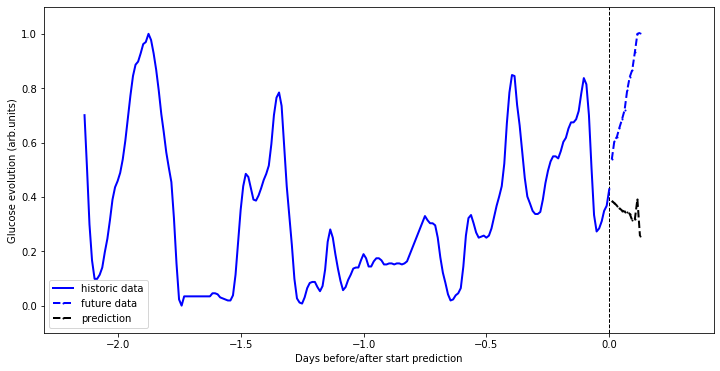

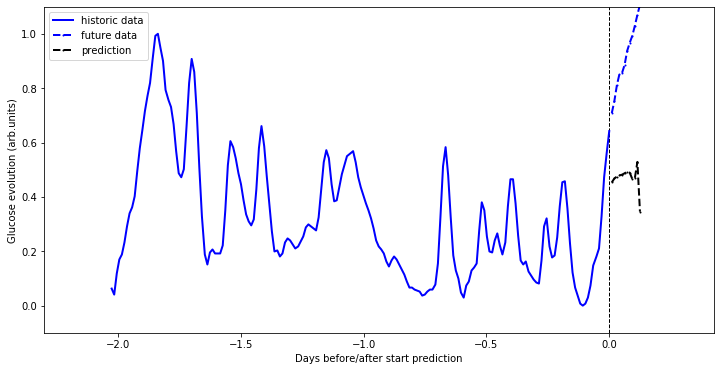

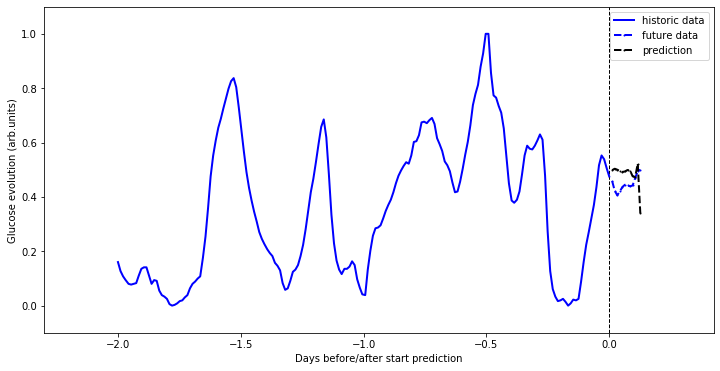

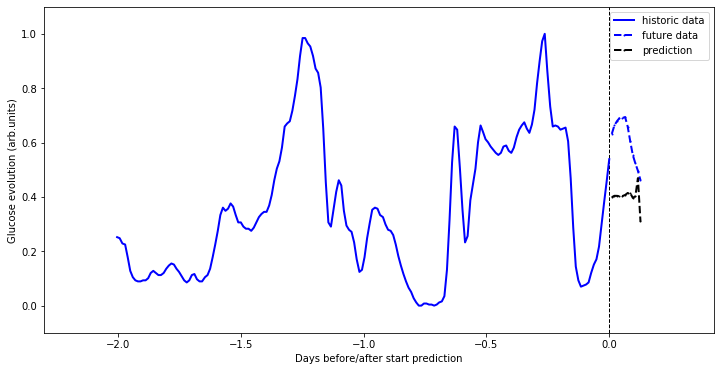

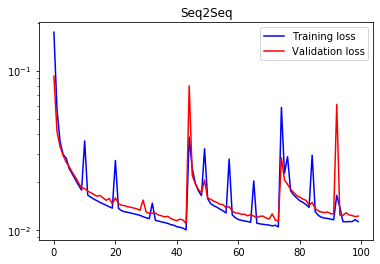

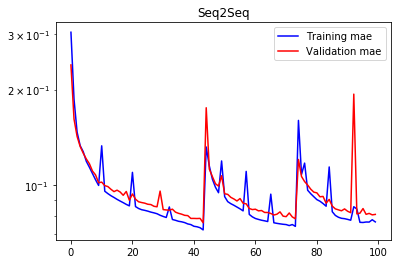

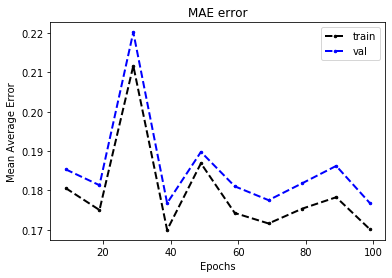

In [0]:
num_epochs = 100

num_layers_enc = 1
neurons = 50
num_features = 4
mn_dense = 0.5
mn_rec = 0.1
layers_dense = [20, 8, 1]
activation_dense = 'selu'
clip_value = 0.3
lr = 5e-4
dropout = 0.0
# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  
verbose = False

prediction_batch = 500
epochs_to_validation = 10
metric = 'mae'
loss = MSE

m, enc, dec, prediction_vad, err_logs, training_logs = train_seq2seq_force(
    train_data, vad_data, train, vad, 
    history, future, start_char, neurons, num_features, num_layers_enc, 
    layers_dense, activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
    lr, clip_value, num_epochs, train_batch, prediction_batch, 
    epochs_to_validation, loss, metric, verbose)


### Retrain best model with train and vad data

In [0]:
a1 = np.concatenate([train_data[0][0], vad_data[0][0]], axis=0)
a2 = np.concatenate([train_data[0][1], vad_data[0][1]], axis=0)
b = np.concatenate([train_data[1], vad_data[1]], axis=0)
train_vad_data = ((a1, a2), b)

msg = "Shapes of train+vad data are: input_enc: {}, input_dec: {} and output_dec: {}"
msg = msg.format(train_vad_data[0][0].shape, train_vad_data[0][1].shape, train_vad_data[1].shape)
print(msg)

Shapes of train+vad data are: input_enc: (93903, 144, 4), input_dec: (93903, 17, 1) and output_dec: (93903, 17, 1)


In [0]:
num_epochs = 150

num_layers = 1
neurons = 200
mn_dense = 0.5
mn_rec = 0.2

full_model, full_enc, full_dec = seq2seq(history, future, latent_dim=neurons, num_features=4, 
                      num_layers_enc=num_layers, activation_dense='elu', 
                      mn_dense=mn_dense, mn_rec=mn_rec)
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4, clipvalue=0.3), 
          loss=MSE, metrics=['mean_absolute_error'])
h = full_model.fit(x=train_vad_data[0], y=train_vad_data[1], batch_size=train_batch, epochs=num_epochs)

### Save best model

In [0]:
root = "/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/models/"
outfolder = os.path.join(root, "noise_%s_train_replace_%s" %(noise, replace))
modelname = "layers_%s_neurons_%s_mn-dense_%.1f_mn-rec_%.1f" %(num_layers, neurons, mn_dense, mn_rec)
outpath = os.path.join(outfolder, modelname)

import re
outpath_bash = re.sub(" ", "\ ", outpath)

!mkdir -p $outpath_bash

full_model.save(os.path.join(outpath, 'seq2seq_model.h5'))
full_enc.save(os.path.join(outpath, 'encoder_model.h5'))
full_dec.save(os.path.join(outpath, 'decoder_model.h5'))

### Evaluate on the test set


In [0]:
prediction_test = decode_sequences(test, enc, dec, history, future, start_char, 
                                   batch_size=500, verbose=True)
err_test = mae(test, prediction_test, history, future)

print("MAE in test set is %.3f" %err_test)

Predicted 500 sequences
Predicted 1000 sequences
Predicted 1500 sequences
Predicted 2000 sequences
Predicted 2500 sequences
Predicted 3000 sequences
Predicted 3500 sequences
Predicted 4000 sequences
Predicted 4500 sequences
Predicted 5000 sequences
Predicted 5500 sequences
Predicted 6000 sequences
Predicted 6500 sequences
Predicted 7000 sequences
Predicted 7500 sequences
Predicted 8000 sequences
Predicted 8500 sequences
Predicted 9000 sequences
Predicted 9500 sequences
Predicted 10000 sequences
MAE in test set is 0.240


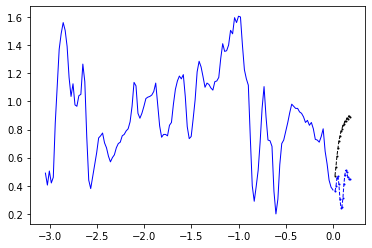

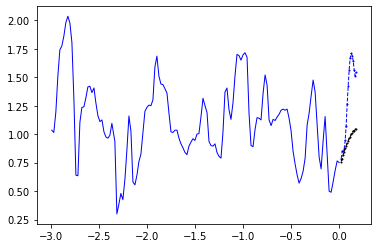

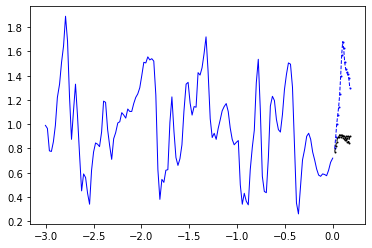

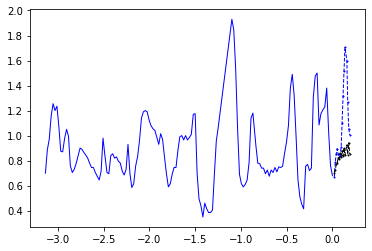

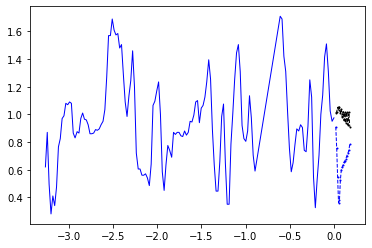

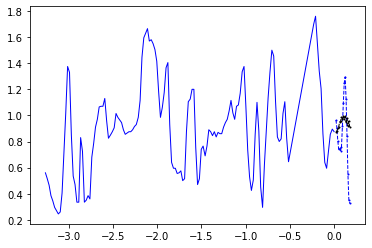

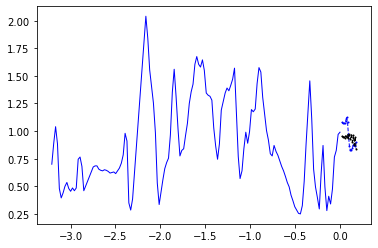

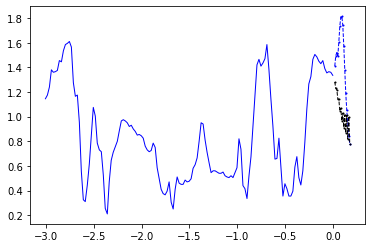

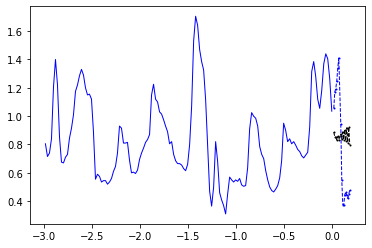

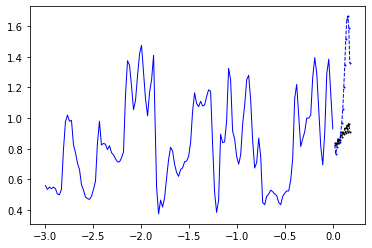

In [0]:
for _ in np.arange(10):
  plot_results(test, prediction_test, history, future)

## Seq2seq with Curriculum Learning

https://www.tensorflow.org/tutorials/text/text_generation

https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/

